# Quantum Fourier Transform

## Goals

1. apply a classical dft for comparison reasons
2. achieve comparable results with the qft


The discrete Fourier transform acts on a vector $(x_0, ..., x_{N-1})$ and maps it to the vector $(y_0, ..., y_{N-1})$ according to the formula


$$y_k = \frac{1}{\sqrt{N}}\sum_{j=0}^{N-1}x_j\omega_N^{jk}$$


where $\omega_N^{jk} = e^{2\pi i \frac{jk}{N}}$.

Similarly, the quantum Fourier transform acts on a quantum state $\sum_{i=0}^{N-1} x_i \vert i \rangle$ and maps it to the quantum state $\sum_{i=0}^{N-1} y_i \vert i \rangle$ according to the formula


$$y_k = \frac{1}{\sqrt{N}}\sum_{j=0}^{N-1}x_j\omega_N^{jk}$$


with $\omega_N^{jk}$ defined as above. Note that only the amplitudes of the state were affected by this transformation.

This can also be expressed as the map:


$$\vert x \rangle \mapsto \frac{1}{\sqrt{N}}\sum_{y=0}^{N-1}\omega_N^{xy} \vert y \rangle$$



Or the unitary matrix:


$$ U_{QFT} = \frac{1}{\sqrt{N}} \sum_{x=0}^{N-1} \sum_{y=0}^{N-1} \omega_N^{xy} \vert y \rangle \langle x \vert$$



In the computational basis, we store numbers in binary using the states $\vert 0\rangle$ and $\vert 1\rangle$

![](https://qiskit.org/textbook/ch-algorithms/images/zbasis-counting.gif "computational basis counting")

In fourier basis, we store numbers using different rotations around the z-axis:

![](https://qiskit.org/textbook/ch-algorithms/images/fourierbasis-counting.gif "fourier basis counting")

The QFT transforms between the computational (Z) and the fourier basis

$$
|\text{State in Computational Basis}\rangle \quad \xrightarrow[]{\text{QFT}} \quad |\text{State in Fourier Basis}\rangle
$$

$$
\text{QFT}|x\rangle = |\widetilde{x}\rangle
$$

Where the states in fourier basis are denoted with tilde (~)

In [350]:
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
# importing Qiskit
from qiskit import *
from qiskit.visualization import plot_histogram

plt.style.use('seaborn-poster')
%matplotlib inline

# Classical (D)FT

First let's do a classical dft on a toy-signal to get familiar again with this whole signal processing topic

In [351]:
def DFT(x):
    """
    Function to calculate the 
    discrete Fourier Transform 
    of a 1D real-valued signal x
    """

    N = len(x)
    n = np.arange(N)
    k = n.reshape((N, 1))
    e = np.exp(-2j * np.pi * k * n / N)
    
    X = np.dot(e, x)
    
    return X

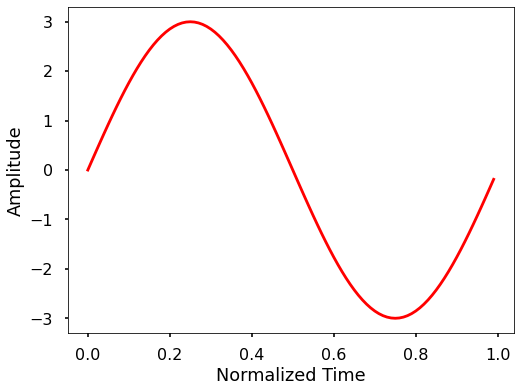

In [352]:
# sampling rate
sr = 100
# sampling interval
ts = 1.0/sr
t = np.arange(0,1,ts)

freq = 1.
x = 3*np.sin(2*np.pi*freq*t)

plt.figure(figsize = (8, 6))
plt.plot(t, x, 'r')
plt.ylabel('Amplitude')
plt.xlabel('Normalized Time')

plt.show()

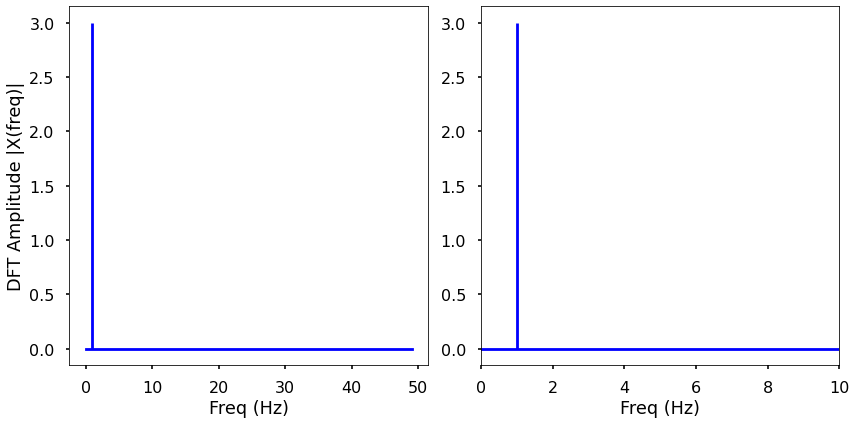

In [353]:
X = DFT(x)

# calculate the frequency
N = len(X)
n = np.arange(N)
T = N/sr
freq = n/T 

n_oneside = N//2
# get the one side frequency
f_oneside = freq[:n_oneside]

# normalize the amplitude
X_oneside =X[:n_oneside]/n_oneside

plt.figure(figsize = (12, 6))
plt.subplot(121)
plt.stem(f_oneside, abs(X_oneside), 'b', \
         markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('DFT Amplitude |X(freq)|')

plt.subplot(122)
plt.stem(f_oneside, abs(X_oneside), 'b', \
         markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.xlim(0, 10)
plt.tight_layout()
plt.show()

# Quantum FT

Next, we let's try to achieve the same result with the qft circuit

In [354]:
def qft_rotations(circuit, n):
    """Performs qft on the first n qubits in circuit (without swaps)"""
    if n == 0:
        return circuit
    n -= 1
    circuit.h(n)
    for qubit in range(n):
        circuit.cp(pi/2**(n-qubit), qubit, n)
    
    
    # At the end of our function, we call the same function again on
    # the next qubits (we reduced n by one earlier in the function)
    qft_rotations(circuit, n)

def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

def measure(circuit, n):
    for qubit in range(n):
        circuit.measure(qubit, 0)

def qft(circuit, n):
    """QFT on the first n qubits in circuit"""
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    measure(circuit,n)
    return circuit

In [355]:
SCALER = 1
def preprocessSignal(signal):
    signal = signal*SCALER
    signal = signal + abs(min(signal))

    return signal

In [356]:
#Parameters:

x_processed = preprocessSignal(x)
# x_processed = x_processed[2:4]
CIRCUIT_SIZE = int(max(x_processed)).bit_length() # this basically defines the "adc resolution"
print(CIRCUIT_SIZE)

3


In [357]:
# qc = QuantumCircuit(CIRCUIT_SIZE)
# qft(qc,CIRCUIT_SIZE)
# qc.draw()


In [358]:
sv_sim = Aer.get_backend("statevector_simulator")



In [359]:
def encodeInteger(encIntegerCircuit, integer):
    if integer.bit_length() > encIntegerCircuit.width():
        raise RuntimeError("Integer too large")

    binary = bin(integer)[2:]
    for i in range(0,min(len(binary),encIntegerCircuit.width()-1)):
        if binary[i] == '1':
            encIntegerCircuit.x(i)

    return encIntegerCircuit

def processQFT(circuit, signal):
    result = list()

    for i in range(0,signal.size):
        circuit = QuantumCircuit(CIRCUIT_SIZE, 1)
        circuit.reset(range(CIRCUIT_SIZE))

        qft(circuit,CIRCUIT_SIZE)
        circuit = encodeInteger(circuit, int(signal[i]))

        backend = Aer.get_backend("qasm_simulator")
        job = execute(circuit, backend, shots=1, memory=True)
        output = job.result().get_memory()[0]

        print(f"Processing index {i} with value {int(signal[i])} yielded {output}")

    return circuit


In [360]:
processQFT(circuit, signal)


Processing index 0 with value 3 yielded 1
Processing index 1 with value 3 yielded 1
Processing index 2 with value 3 yielded 0
Processing index 3 with value 3 yielded 1
Processing index 4 with value 3 yielded 0
Processing index 5 with value 3 yielded 1
Processing index 6 with value 4 yielded 1
Processing index 7 with value 4 yielded 0
Processing index 8 with value 4 yielded 1
Processing index 9 with value 4 yielded 1
Processing index 10 with value 4 yielded 1
Processing index 11 with value 4 yielded 0
Processing index 12 with value 5 yielded 1
Processing index 13 with value 5 yielded 0
Processing index 14 with value 5 yielded 1
Processing index 15 with value 5 yielded 1
Processing index 16 with value 5 yielded 0
Processing index 17 with value 5 yielded 0
Processing index 18 with value 5 yielded 1
Processing index 19 with value 5 yielded 0
Processing index 20 with value 5 yielded 0
Processing index 21 with value 5 yielded 0
Processing index 22 with value 5 yielded 0
Processing index 23 w

[]

In [361]:
circuit.draw()


AttributeError: module 'qiskit.circuit' has no attribute 'draw'